In [1]:
import os 
import torch
import numpy as np
import torch
import torch.optim as optim
import random
import json
import time
import cv2
from torch.utils.data import DataLoader
from celebA import CelebA

from torch.utils.data import DataLoader

from model import Encoder, Decoder, Classifier
from model_loss import diff_loss, recon_loss, classify_loss
from opts import parse_opts
from torchvision import transforms
import matplotlib.pyplot as plt

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def bar(current, total, prefix="", suffix="", bar_sz=25, end_string=None):
    sp = ""
    print("\x1b[2K\r", end='')
    for i in range(bar_sz):
        if current * bar_sz // total > i:
            sp += '='
        elif current * bar_sz // total == i:
            sp += '>'
        else:
            sp += ' '
    if current == total:
        if end_string is None:
            print("\r%s[%s]%s" % (prefix, sp, suffix))
        else:
            if end_string != "":
                print("\r%s" % end_string)
            else:
                print("\r", end='')
    else:
        print("\r%s[%s]%s" % (prefix, sp, suffix), end='')
    
def psnr(outputs, targets):
    # [batch, channel, width, height]
    num_pixels = outputs.shape[2] * outputs.shape[3]
    batch_size = outputs.shape[0]
    seq_length = outputs.shape[1]
    psnr = torch.zeros((outputs.shape[0],outputs.shape[1]))
    for i in range(batch_size):
            mse = torch.mean((outputs[i,:,:,:] - targets[i,:,:,:])**2)
            psnr[i] = 20 * torch.log10(torch.max(outputs[i,:,:,:])) - 10 * torch.log10(mse)
    return torch.mean(psnr)

# show image
def imshow(img, title=None):
    unloader = transforms.ToPILImage() 
    b = img[0,:,:].cpu().clone()
    g = img[1,:,:].cpu().clone()
    r = img[2,:,:].cpu().clone()
    image = torch.stack([r,g,b],dim=0)  # remove the fake batch dimension
    image = unloader(image)
    plt.figure()
    plt.imshow(image)
    print('show img...')
    if title is not None:
        plt.title(title)  
        
def imsave(img, title, path):
    b = img[0,:,:].cpu().clone()
    g = img[1,:,:].cpu().clone()
    r = img[2,:,:].cpu().clone()
    image = torch.stack([r,g,b],dim=0)  # remove the fake batch dimension
    save_path = os.path.join(path,title+'.jpg')
    image = (image*255.0).permute(1,2,0).byte().numpy()
    print('save img...')
    cv2.imwrite(save_path,image)
        

In [21]:
args={'ann_file':'data/annotation.json','image_dir':'../celebA/img_align_celeba','batch_size':64,'att_num':1}

#split training and validation dataset
pair_list = json.load(open('data/select_data_1_downsample.json','r'))
random.shuffle(pair_list)
train_index_list = pair_list[:int(0.8*len(pair_list))]
eval_index_list = pair_list[int(0.8*len(pair_list)):]

transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()])
transform_val = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()])

train_dataset = CelebA(args['ann_file'], args['image_dir'], train_index_list, transform_train, transform_train,args['att_num'])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'], num_workers=16)
val_dataset = CelebA(args['ann_file'], args['image_dir'], eval_index_list, transform_val, transform_val,args['att_num'])
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=args['batch_size'], num_workers=16)

###############################################################################
# Build the model
###############################################################################
encoder = Encoder()
decoder = Decoder(att_num=args['att_num'])
classifier = Classifier(args['att_num'])

encoder.cuda()
decoder.cuda()
classifier.cuda()

Classifier(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    

In [ ]:
###############################################################################
# Resume model
###############################################################################

resume_path = '../result/en_de_att_1_balance/checkpoint_31.pth'
checkpoint = torch.load(resume_path)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
classifier.load_state_dict(checkpoint['classifier'])


###############################################################################
# Visiualization
###############################################################################
loss_z_val = AverageMeter()
loss_recon_val = AverageMeter()
loss_classify_val = AverageMeter()
loss_val = AverageMeter()
psnr_val = AverageMeter()
encoder.eval()
decoder.eval()
classifier.eval()

In [42]:
data_iter = iter(val_loader)
# show and save images        
img_save_path='../result/en_de_att_1_balance/img/'

In [43]:
data = data_iter.next()

In [ ]:
batch_start_time = time.time()
img_1 = data[0].cuda()
img_2 = data[1].cuda()
img_1_atts = data[2].cuda()
img_2_atts = data[3].cuda() 

In [91]:
z_1 = encoder(img_1)
z_2 = encoder(img_2)
img_2_trans = decoder(z_1, img_2_atts)
img_1_trans = decoder(z_2, img_1_atts)
img_1_recon = decoder(z_1, img_1_atts)
img_2_recon = decoder(z_2, img_2_atts)
img_1_atts_pre = classifier(img_1_trans)
img_2_atts_pre = classifier(img_2_trans)

In [48]:
i = 5

In [88]:
print(img_1_atts[i])
print(img_1_atts_pre[i])
print(img_2_atts[i])
print(img_2_atts_pre[i])

tensor([0.], device='cuda:0')
tensor([3.6867e-06], device='cuda:0', grad_fn=<SelectBackward>)
tensor([1.], device='cuda:0')
tensor([1.0000], device='cuda:0', grad_fn=<SelectBackward>)


show img...
tensor([6.5359e-07], device='cuda:0', grad_fn=<SelectBackward>)
show img...
tensor([1.1752e-10], device='cuda:0', grad_fn=<SelectBackward>)
show img...
tensor([1.], device='cuda:0', grad_fn=<SelectBackward>)
show img...
tensor([1.], device='cuda:0', grad_fn=<SelectBackward>)
show img...
tensor([1.], device='cuda:0', grad_fn=<SelectBackward>)
show img...
tensor([2.0357e-06], device='cuda:0', grad_fn=<SelectBackward>)


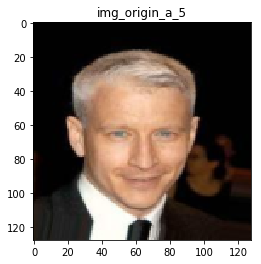

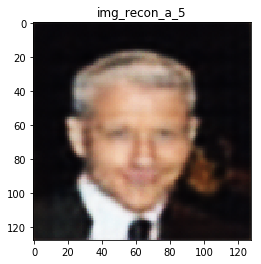

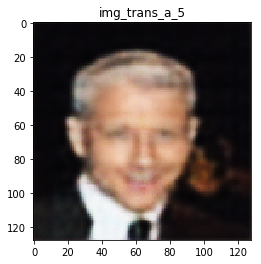

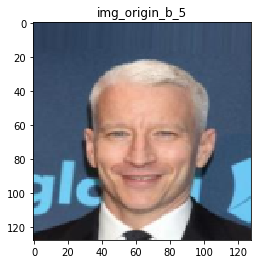

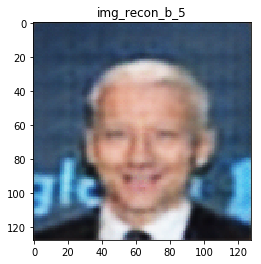

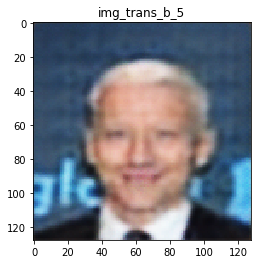

In [92]:
img_name_origin_a='img_origin_a_'+str(i)
img_name_recon_a='img_recon_a_'+str(i)    
img_name_trans_a='img_trans_a_'+str(i)
img_name_origin_b='img_origin_b_'+str(i)
img_name_recon_b='img_recon_b_'+str(i)    
img_name_trans_b='img_trans_b_'+str(i)
imshow(img_1[i], title=img_name_origin_a)
print(classifier(img_1)[i])
imshow(img_1_recon[i], title=img_name_recon_a)
print(classifier(img_1_recon)[i])
imshow(img_2_trans[i], title=img_name_trans_a)
print(classifier(img_2_trans)[i])
imshow(img_2[i], title=img_name_origin_b)
print(classifier(img_2)[i])
imshow(img_2_recon[i], title=img_name_recon_b)
print(classifier(img_2_recon)[i])
imshow(img_1_trans[i], title=img_name_trans_b)
print(classifier(img_1_trans)[i])

In [99]:
img_save_path='../result/en_de_att_1/img/'
imsave(img_1[i], img_name_origin_a, img_save_path)
imsave(img_1_recon[i], img_name_recon_a, img_save_path)
imsave(img_2_trans[i], img_name_trans_a, img_save_path)
imsave(img_2[i], img_name_origin_b, img_save_path)
imsave(img_2_recon[i], img_name_recon_b, img_save_path)
imsave(img_1_trans[i], img_name_trans_b, img_save_path)

save img...
save img...
save img...
save img...
save img...
save img...


In [23]:
epoch = 0
epoch_start_time = time.time()
loss_classify = AverageMeter()
loss = AverageMeter()
classifier.train()
for batch_idx, data in enumerate(train_loader):
    batch_start_time = time.time()
    img_1 = data[0].cuda()
    img_2 = data[1].cuda()
    img_1_atts = data[2].cuda()
    img_2_atts = data[3].cuda() 

    img_1_atts_pre = classifier(img_1)
    img_2_atts_pre = classifier(img_2)
    loss_classify_cur = classify_loss(img_1_atts_pre, img_1_atts) + classify_loss(img_2_atts_pre, img_2_atts)                       
    loss_cur = loss_classify_cur

    #optimizer.zero_grad()
    #loss_classify_cur.backward()

    #optimizer.step()

    loss_classify.update(loss_classify_cur.item())
    loss.update(loss_cur.item())
    batch_time = time.time() - batch_start_time         
    bar(batch_idx, len(train_loader), "Epoch: {:3d} | ".format(epoch),
    ' | time {batch_time:.3f} | loss {loss.val:.5f} | loss_classify {loss_classify.val:.5f}  |'.format(
        batch_time=batch_time, loss=loss, loss_classify=loss_classify), end_string="")

loss_classify_val = AverageMeter()
loss_val = AverageMeter()

classifier.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(val_loader):
        batch_start_time = time.time()
        img_1 = data[0].cuda()
        img_2 = data[1].cuda()
        img_1_atts = data[2].cuda()
        img_2_atts = data[3].cuda() 

        img_1_atts_pre = classifier(img_1)
        img_2_atts_pre = classifier(img_2)

        loss_classify_cur = classify_loss(img_1_atts_pre, img_1_atts) + classify_loss(img_2_atts_pre, img_2_atts)           

        loss_cur = loss_classify_cur

        loss_classify_val.update(loss_classify_cur.item())
        loss_val.update(loss_cur.item())
        batch_time = time.time() - batch_start_time         
        bar(batch_idx, len(val_loader), "Epoch: {:3d} | ".format(epoch),
        ' | time {:.3f} | loss_val {:.5f} | loss_classify_val {:.5f}  |'.format(
            batch_time, loss_val.val, loss_classify_val.val), end_string="")

    print('\n| end of epoch {:3d} | time: {:5.5f}s | valid loss {:.5f} |' 
        ' valid classify loss {:.5f}'
            .format(epoch, (time.time() - epoch_start_time),loss_val.avg, loss_classify_val.avg))

Epoch:   0 | [========================>] | time 0.065 | loss_val 0.00005 | loss_classify_val 0.00005  |
| end of epoch   0 | time: 55.88492s | valid loss 0.00050 | valid classify loss 0.00050


In [22]:
resume_path = '../result/classifier_att_1_balance/checkpoint_15.pth'
checkpoint = torch.load(resume_path)
classifier.load_state_dict(checkpoint['classifier'])